<a href="https://colab.research.google.com/github/Tabook22/ComputerVision/blob/main/colorize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:** Dr. Shahriar Hossain <br>
**Topic of the code:** Colorize Black and White Images <br>
**Video explaining this code:** https://youtu.be/WXyeQeHUxpc <br>
**My YT Channel:** https://www.youtube.com/@C4A <br>
**Web:** https://computing4all.com/ <br>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In the following code we are going to use PyTorch library, which is a popular deep learning framework. The code is used to set up and check the availability of NVIDIA CUDA devices (typically GPUs) for computation.<br>
<strong>CUDA</strong> is an API developed by NVIDIA that allows developers to leverage the parallel processing capabilities of NVIDIA GPUs for general-purpose computation, beyond just graphics rendering. It provides a set of tools, libraries, and language extensions to facilitate GPU-accelerated application development.

In [2]:
# Set device
#torch.device: This is a PyTorch function that returns a device object which can be used to move tensors to either CPU or CUDA (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#torch.cuda.is_available(): This function checks if CUDA (NVIDIA's parallel computing platform and API) is available on the system. If CUDA is available, it means you can use the GPU for computation.
if torch.cuda.is_available():
  print(torch.cuda.current_device())
  print(torch.cuda.device(0))
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  print("No NVIDIA driver found. Using CPU")

0
1
Tesla T4


In [3]:
# Load the CIFAR-10 dataset
#The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

#The code below sets up the necessary components to load and preprocess the CIFAR-10 dataset for both training and testing in a deep learning model using PyTorch.

#transforms.Compose(): This function allows you to chain together multiple image transformations.
#transforms.ToTensor(): This transformation converts a PIL (Python Imaging Library) image or a numpy array to a PyTorch tensor. It also scales the image's pixel intensity values from [0, 255] (integers) to [0, 1] (floats).
transform = transforms.Compose([
    transforms.ToTensor(),
])

#torchvision.datasets.CIFAR10(): This function fetches the CIFAR-10 dataset.
#root='./data': Specifies the directory where the dataset will be stored.
#train=True: Indicates that we want the training portion of the CIFAR-10 dataset.
#download=True: If the dataset is not present in the specified directory, it will be downloaded.
#transform=transform: Applies the previously defined transformations to the images.
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#torch.utils.data.DataLoader(): This function creates a data loader, which allows you to efficiently iterate over the dataset in batches.
#batch_size=64: Specifies that 64 images will be loaded in each iteration.
#shuffle=True: The training data will be shuffled at the beginning of each epoch to introduce randomness during training.
#num_workers=2: Uses 2 subprocesses to load the data. This can speed up data loading.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

#Similar to the training dataset, but with train=False to indicate that we want the test portion of the CIFAR-10 dataset.
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#Similar to the training data loader, but with shuffle=False since there's no need to shuffle the test data.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 49323617.77it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Define the colorization model
#This code defines a neural network model for colorization, which is the process of adding color to grayscale images. The model is designed using the PyTorch deep learning framework

#The ColorizationNet class is defined, which inherits from nn.Module. In PyTorch, custom neural network architectures are typically defined as classes that inherit from nn.Module.
class ColorizationNet(nn.Module):
  #This is the constructor of the ColorizationNet class. It initializes the layers of the neural network.
  #super(ColorizationNet, self).__init__(): This line calls the constructor of the parent class (nn.Module).
  #nn.Conv2d(...): These lines define 2D convolutional layers. The parameters specify the number of input channels, output channels, kernel size, stride, padding, and dilation.
  #For instance, nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2) defines a convolutional layer that takes in a grayscale image (1 channel) and outputs 64 feature maps using a 5x5 kernel.
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv4 = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=4, dilation=2)

  #This method defines the forward pass of the neural network. It specifies how the input data x (grayscale image) is transformed as it passes through the network layers.
  #nn.functional.relu(...): This applies the ReLU (Rectified Linear Unit) activation function, which introduces non-linearity to the model.
  #torch.sigmoid(...): This applies the sigmoid activation function to the output of the last convolutional layer. The sigmoid function squashes the output values between 0 and 1,
  #which can be interpreted as pixel intensity values for the colorized image.
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x

    #In summary, the ColorizationNet class defines a simple neural network model for colorizing grayscale images. The model consists of four convolutional layers, with ReLU activations applied to the first three layers
    #and a sigmoid activation applied to the output layer. The goal of this model would be to take a grayscale image as input and produce a colorized version of the image as output.

In [5]:
model = ColorizationNet().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert RGB image to grayscale
def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True)


In [6]:
# Training loop
EPOCHS = 30
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        images = images.to(device)

        # Forward pass
        outputs = model(grayscale_images)
        loss = criterion(outputs, images)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

print("Finished Training")


Epoch [1/30], Step [1/782], Loss: 0.0644
Epoch [1/30], Step [101/782], Loss: 0.0104
Epoch [1/30], Step [201/782], Loss: 0.0065
Epoch [1/30], Step [301/782], Loss: 0.0066
Epoch [1/30], Step [401/782], Loss: 0.0048
Epoch [1/30], Step [501/782], Loss: 0.0054
Epoch [1/30], Step [601/782], Loss: 0.0053
Epoch [1/30], Step [701/782], Loss: 0.0067
Epoch [2/30], Step [1/782], Loss: 0.0049
Epoch [2/30], Step [101/782], Loss: 0.0059
Epoch [2/30], Step [201/782], Loss: 0.0063
Epoch [2/30], Step [301/782], Loss: 0.0061
Epoch [2/30], Step [401/782], Loss: 0.0050
Epoch [2/30], Step [501/782], Loss: 0.0052
Epoch [2/30], Step [601/782], Loss: 0.0046
Epoch [2/30], Step [701/782], Loss: 0.0068
Epoch [3/30], Step [1/782], Loss: 0.0045
Epoch [3/30], Step [101/782], Loss: 0.0052
Epoch [3/30], Step [201/782], Loss: 0.0059
Epoch [3/30], Step [301/782], Loss: 0.0050
Epoch [3/30], Step [401/782], Loss: 0.0075
Epoch [3/30], Step [501/782], Loss: 0.0046
Epoch [3/30], Step [601/782], Loss: 0.0069
Epoch [3/30], Ste

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Convert from Tensor image and display
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    if len(img.shape) == 2:  # grayscale image
        plt.imshow(npimg, cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualize_all_three(original_images, grayscale_images, colorized_images, n=5):
    """
    Display grayscale, colorized, and original images side by side.
    n: number of images to display from the batch
    """
    fig = plt.figure(figsize=(3*n, 4))
    for i in range(n):
        # Display original image
        ax = plt.subplot(1, 3*n, 3*i + 1)
        imshow(original_images[i])
        ax.set_title("Original")
        ax.axis("off")

        # Display original grayscale image
        ax = plt.subplot(1, 3*n, 3*i + 2)
        imshow(grayscale_images[i])
        ax.set_title("Grayscale")
        ax.axis("off")

        # Display colorized image
        ax = plt.subplot(1, 3*n, 3*i + 3)
        imshow(colorized_images[i])
        ax.set_title("Colorized")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def torch_rgb_to_hsv(rgb):
    """
    Convert an RGB image tensor to HSV.

    Parameters:
    - rgb: tensor of shape (batch_size, 3, height, width) in RGB format in the range [0, 1].

    Returns:
    - hsv: tensor of same shape in HSV format in the range [0, 1].
    """
    r, g, b = rgb[:, 0, :, :], rgb[:, 1, :, :], rgb[:, 2, :, :]
    max_val, _ = torch.max(rgb, dim=1)
    min_val, _ = torch.min(rgb, dim=1)
    diff = max_val - min_val

    # Compute H
    h = torch.zeros_like(r)
    mask = (max_val == r) & (g >= b)
    h[mask] = (g[mask] - b[mask]) / diff[mask]
    mask = (max_val == r) & (g < b)
    h[mask] = (g[mask] - b[mask]) / diff[mask] + 6.0
    mask = max_val == g
    h[mask] = (b[mask] - r[mask]) / diff[mask] + 2.0
    mask = max_val == b
    h[mask] = (r[mask] - g[mask]) / diff[mask] + 4.0
    h = h / 6.0
    h[diff == 0.0] = 0.0

    # Compute S
    s = torch.zeros_like(r)
    s[diff != 0.0] = diff[diff != 0.0] / max_val[diff != 0.0]

    # V is just max_val
    v = max_val

    return torch.stack([h, s, v], dim=1)


def torch_hsv_to_rgb(hsv):
    """
    Convert an HSV image tensor to RGB.

    Parameters:
    - hsv: tensor of shape (batch_size, 3, height, width) in HSV format in the range [0, 1].

    Returns:
    - rgb: tensor of same shape in RGB format in the range [0, 1].
    """
    h, s, v = hsv[:, 0, :, :], hsv[:, 1, :, :], hsv[:, 2, :, :]
    i = (h * 6.0).floor()
    f = h * 6.0 - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    i_mod = i % 6
    r = torch.zeros_like(h)
    g = torch.zeros_like(h)
    b = torch.zeros_like(h)

    r[i_mod == 0.0] = v[i_mod == 0.0]
    g[i_mod == 0.0] = t[i_mod == 0.0]
    b[i_mod == 0.0] = p[i_mod == 0.0]

    r[i_mod == 1.0] = q[i_mod == 1.0]
    g[i_mod == 1.0] = v[i_mod == 1.0]
    b[i_mod == 1.0] = p[i_mod == 1.0]

    r[i_mod == 2.0] = p[i_mod == 2.0]
    g[i_mod == 2.0] = v[i_mod == 2.0]
    b[i_mod == 2.0] = t[i_mod == 2.0]

    r[i_mod == 3.0] = p[i_mod == 3.0]
    g[i_mod == 3.0] = q[i_mod == 3.0]
    b[i_mod == 3.0] = v[i_mod == 3.0]

    r[i_mod == 4.0] = t[i_mod == 4.0]
    g[i_mod == 4.0] = p[i_mod == 4.0]
    b[i_mod == 4.0] = v[i_mod == 4.0]

    r[i_mod == 5.0] = v[i_mod == 5.0]
    g[i_mod == 5.0] = p[i_mod == 5.0]
    b[i_mod == 5.0] = q[i_mod == 5.0]

    return torch.stack([r, g, b], dim=1)

def exaggerate_colors(images, saturation_factor=1.5, value_factor=1.2):
    """
    Exaggerate the colors of RGB images.

    Parameters:
    - images: tensor of shape (batch_size, 3, height, width) in RGB format.
    - saturation_factor: factor by which to increase the saturation. Default is 1.5.
    - value_factor: factor by which to increase the value/brightness. Default is 1.2.

    Returns:
    - color_exaggerated_images: tensor of same shape as input, with exaggerated colors.
    """
    # Convert images to the range [0, 1]
    images = (images + 1) / 2.0

    # Convert RGB images to HSV
    images_hsv = torch_rgb_to_hsv(images)

    # Increase the saturation and value components
    images_hsv[:, 1, :, :] = torch.clamp(images_hsv[:, 1, :, :] * saturation_factor, 0, 1)
    images_hsv[:, 2, :, :] = torch.clamp(images_hsv[:, 2, :, :] * value_factor, 0, 1)

    # Convert the modified HSV images back to RGB
    color_exaggerated_images = torch_hsv_to_rgb(images_hsv)

    # Convert images back to the range [-1, 1]
    color_exaggerated_images = color_exaggerated_images * 2.0 - 1.0

    return color_exaggerated_images



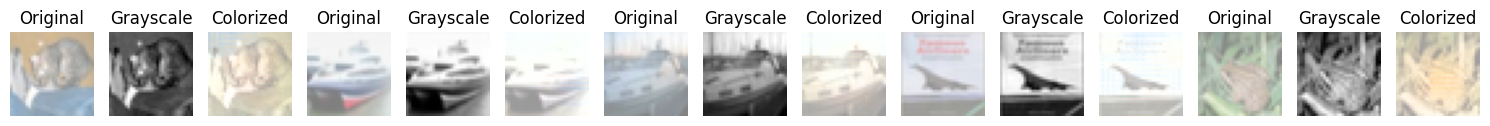

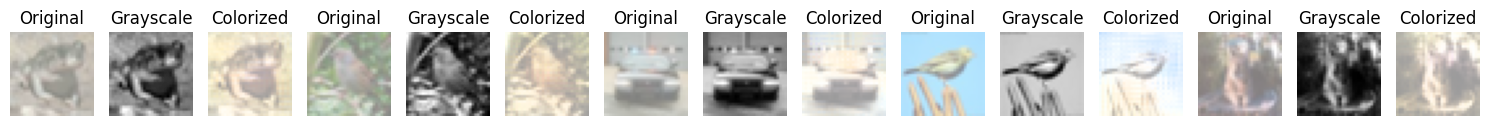

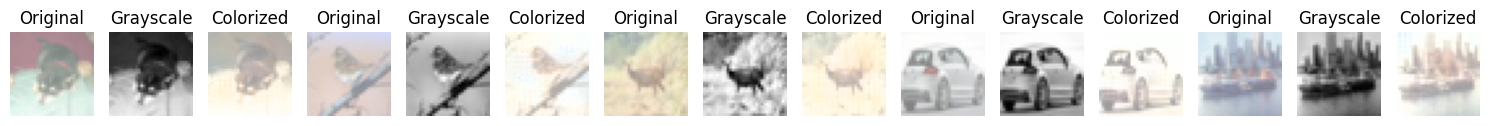

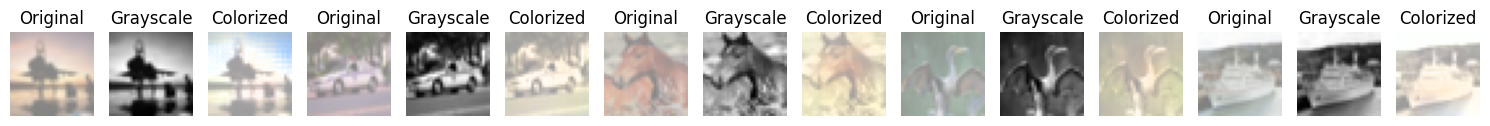

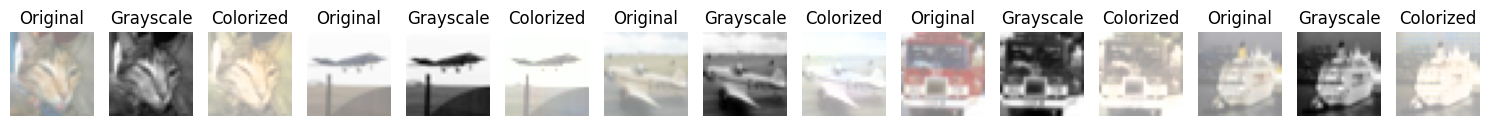

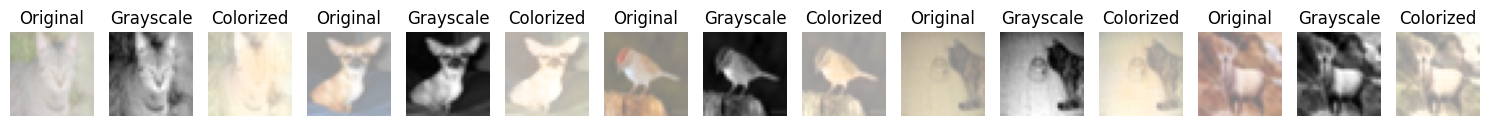

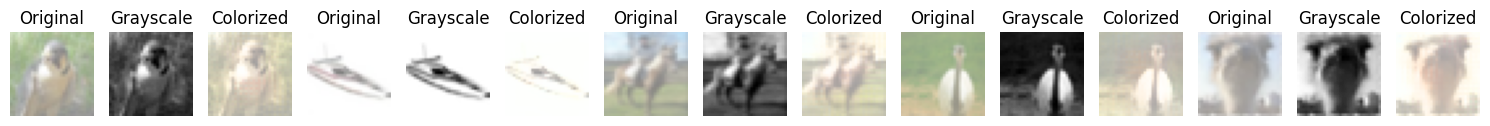

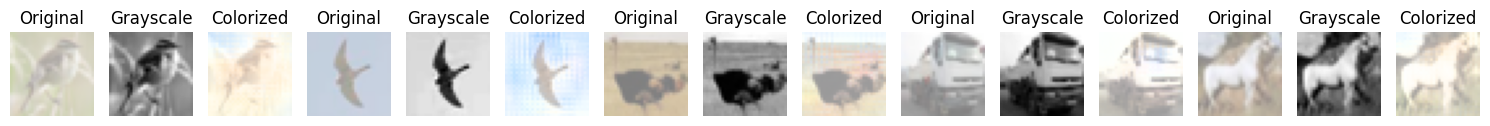

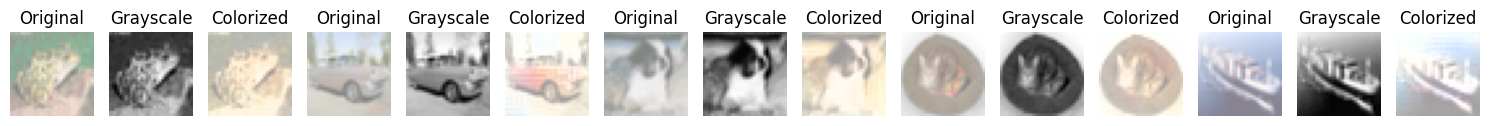

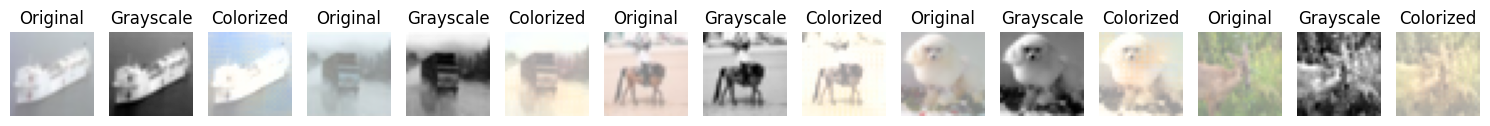

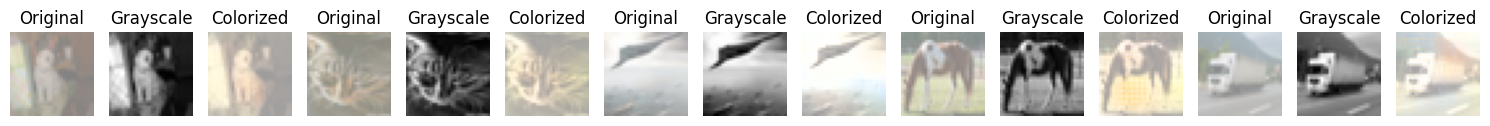

In [8]:
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        colorized_images = model(grayscale_images)

        # Convert the tensors back to CPU for visualization
        grayscale_images_cpu = grayscale_images.cpu().squeeze(1)  # remove the color channel
        colorized_images_cpu = colorized_images.cpu()
        original_images_cpu = images.cpu()

        #colorized_images_cpu=scale_predicted_colors(colorized_images_cpu)
        colorized_images_cpu=exaggerate_colors(colorized_images_cpu)

        # Visualize the grayscale, colorized, and original images
        visualize_all_three(original_images_cpu, grayscale_images_cpu, colorized_images_cpu)

        if i == 10:  # only do this for up to certain batch for demonstration purposes
            break

In [15]:
from PIL import Image

# Open the image. (Keep your image in the current directory. In my case, the image was horse.jpg)
img = Image.open("./author.png")

# Convert the image to grayscale
gray_img = img.convert("L")

# New Section

In [16]:
import torchvision.transforms as transforms

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # If you need to normalize, uncomment the following line
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming you want to normalize to [-1, 1] range
])



In [17]:
# Apply the transformations
img_tensor = transform(gray_img).unsqueeze(0)  # Add a batch dimension

# Ensure the model is in evaluation mode
model.eval()

# Move the image tensor to the device where your model is (likely 'cuda' if using GPU)
img_tensor = img_tensor.to(device)

# Get the model's output
with torch.no_grad():
    colorized_tensor = model(img_tensor)


In [18]:
# Convert the tensor back to an image
colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze(0).cpu())

# Optionally, save the image
colorized_img.save("./horse_colorized.jpg")


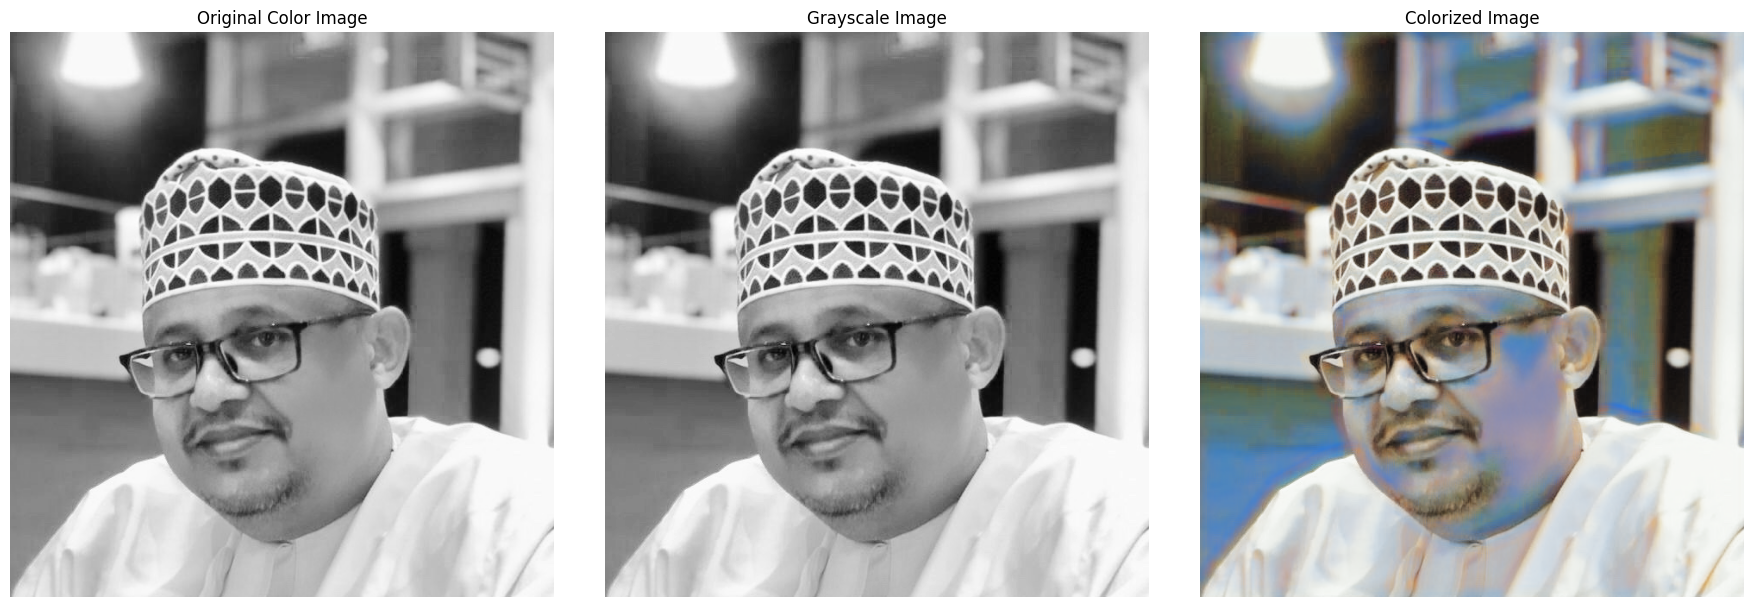

In [19]:
# Plotting the original, grayscale, and colorized images side-by-side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure with 1 row and 3 columns

# Display original color image
ax[0].imshow(img)
ax[0].set_title("Original Color Image")
ax[0].axis('off')  # Hide axes

# Display grayscale image
ax[1].imshow(gray_img, cmap='gray')  # Since it's grayscale, use cmap='gray'
ax[1].set_title("Grayscale Image")
ax[1].axis('off')  # Hide axes

# Display colorized image
ax[2].imshow(colorized_img)
ax[2].set_title("Colorized Image")
ax[2].axis('off')  # Hide axes

plt.tight_layout()  # Adjust spacing
plt.show()

In [20]:
gray_img.save("./author.png")